In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import json

import skimage, skimage.io, skimage.transform, skimage.filters
import sklearn, sklearn.metrics

import importlib

import sys
sys.path.append('../src/')
import modutils

In [2]:
def extract_words_from_dataset(jdata, acceptable_statuses):
    def process_words(words):
        return [(w['text'], w['filename']) for w in words if 'status' in w and w['status'] in acceptable_statuses]
    def process_lines(lines):
        res = [process_words(x['words']) for x in lines]
        return [x for y in res for x in y]
    res = [(process_lines(v['lines']), v['name']) for (k, v) in jdata.items()]
    return [(x[0], name+'/'+x[1]) for (y, name) in res for x in y]

def downscale_x(img, scale):
    if scale > 1.0:
        raise Exception("downscale: scale must be <= 1.0")
    if scale == 1.0:
        return img
    tmp = skimage.transform.rescale(img, (1.0, scale), mode='constant', cval=1.0)
    diff = img.shape[1] - tmp.shape[1]
    d1 = diff // 2
    d2 = diff - d1
    return np.hstack([np.ones((tmp.shape[0], d1)), tmp,np.ones((tmp.shape[0], d2))])

def downscale_y(img, scale):
    if scale > 1.0:
        raise Exception("downscale: scale must be <= 1.0")
    if scale == 1.0:
        return img
    tmp = skimage.transform.rescale(img, (scale, 1.0), mode='constant', cval=1.0)
    diff = img.shape[0] - tmp.shape[0]
    d1 = diff // 2
    d2 = diff - d1
    return np.vstack([np.ones((d1, tmp.shape[1])), tmp,np.ones((d2, tmp.shape[1]))])

def upscale_x(img, scale):
    if scale < 1.0:
        raise Exception("uscale: scale must be >= 1.0")
    if scale == 1.0:
        return img
    tmp = skimage.transform.rescale(img, (1.0, scale), mode='constant', cval=1.0)
    diff = tmp.shape[1]-img.shape[1]
    d0 = diff // 2
    return tmp[:, d0:(img.shape[1]+d0)]


def upscale_y(img, scale):
    if scale < 1.0:
        raise Exception("uscale: scale must be >= 1.0")
    if scale == 1.0:
        return img
    tmp = skimage.transform.rescale(img, (scale, 1.0), mode='constant', cval=1.0)
    diff = tmp.shape[0]-img.shape[0]
    d0 = diff // 2
    return tmp[d0:(img.shape[0]+d0), :]

def rescale(img, scale):
    xs = scale
    ys = scale
    if type(scale) in (list, tuple):
        xs = scale[0]
        ys = scale[1]
    xfn = downscale_x if xs < 1.0 else upscale_x
    yfn = downscale_y if ys < 1.0 else upscale_y
    return yfn(xfn(img, xs), ys)

def trim_image_width(img):
    tmp = np.max(img, axis=0)>0
    id1 = np.argmax(tmp)
    id2 = len(tmp) - np.argmax(tmp[::-1])
    return img[:, id1:id2]

def trim_image_height(img):
    tmp = np.max(img, axis=1)>0
    id1 = np.argmax(tmp)
    id2 = len(tmp) - np.argmax(tmp[::-1])
    return img[id1:id2, :]

def perform_transform(img, transform):
    if type(transform) == list:
        res = img
        for t in transform:
            res = perform_transform(res, t)
        return res
    if type(transform) != dict:
        raise Exception("perform_transform() expected parameter 'transform' to be dict!")
    if 'type' not in transform:
        raise Exception("perform_transform() parameter 'transform' should have valid 'type' value!")
    if transform['type'] == 'rotate':
        return skimage.transform.rotate(img, transform.get('angle', 0), mode='constant', cval=1.0)
    if transform['type'] == 'shift':
        inv_map = np.array([[1,0,-transform.get('x', 0)*img.shape[0]],
                              [0,1,-transform.get('y', 0)*img.shape[0]],
                              [0,0,1]])
        return skimage.transform.warp(img, inv_map, mode='constant', cval=1.0)
    if transform['type'] == 'cutoff':
        return 1.0*(img < transform.get('cutoff', 0.5))
    if transform['type'] == 'scale':
        return rescale(img, (transform.get('x', 1.0), transform.get('y', 1.0)))
    if transform['type'] == 'resize':
        xs = transform.get('x', None)
        ys = transform.get('y', None)
        if xs is None and ys is None:
            raise Exception("perform_transform() parameter 'transform' should have at least one x or y for resize!")
        if xs is None:
            xs = int(ys / img.shape[0] * img.shape[1])
        if ys is None:
            ys = int(xs / img.shape[1] * img.shape[0])
        return skimage.transform.resize(img, (ys, xs), mode='constant', cval=1.0)
    if transform['type'] == 'trimx':
        return trim_image_width(img)
    if transform['type'] == 'trimy':
        return trim_image_height(img)
    
def generate_rotations(min_angle, max_angle, num):
    return [{'type':'rotate', 'angle':x} for x in np.linspace(min_angle, max_angle, num)]

def generate_scales(min_scale, max_scale, num):
    return [{'type':'scale', 'x':x, 'y':y}
        for x in np.linspace(min_scale, max_scale, num)
        for y in np.linspace(min_scale, max_scale, num)]

def generate_shifts(min_shift, max_shift, num):
    return [{'type':'shift', 'x':x, 'y':y}
        for x in np.linspace(min_shift, max_shift, num)
        for y in np.linspace(min_shift, max_shift, num)]

def generate_cutoffs(min_cutoff, max_cutoff, num):
    return [{'type':'cutoff', 'cutoff':x} for x in np.linspace(min_cutoff, max_cutoff, num)]


def generate_combinations2(transform_set1, transform_set2):
    return [(x if type(x) == list else [x]) + (y if type(y) == list else [y])
        for x in transform_set1 for y in transform_set2]

def generate_combinations(*sets):
    if len(sets) == 1:
        return sets[0]
    if len(sets) == 2:
        return generate_combinations2(sets[0], sets[1])
    args = [generate_combinations2(sets[0], sets[1])] + list(sets[2:])
    return generate_combinations(*args)

def append_transformations(transform_sets, pre_transforms=[], post_transforms=[]):
    return [pre_transforms + (x if type(x) == list else [x]) + post_transforms
            for x in transform_sets]

In [3]:
fname = '../data/ru_calibration.json'
extraction_path = os.path.join(os.path.dirname(fname),
                               os.path.basename(fname).split('.')[0])
with open(fname, 'r', encoding='utf-8') as f:
    src = json.load(f)
    
words = extract_words_from_dataset(src, (1,))

In [4]:
tmp = skimage.io.imread(os.path.join(extraction_path, words[2][1]), as_grey=True)

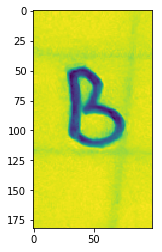

In [5]:
plt.imshow(tmp)

In [6]:
transforms_rotation = generate_rotations(-10, 10, 5)
transforms_scale = generate_scales(0.75, 1.25, 5)
transforms_shift = generate_shifts(-0.1, 0.1, 5)
transforms_cutoff = generate_cutoffs(0.3, 0.5, 5)
combinations_all = generate_combinations(transforms_rotation, transforms_shift,
                                       transforms_scale, transforms_cutoff)

fixed_post = [{'type':'trimx'},{'type':'trimy'}, {'type':'resize', 'y':32}]
transforms_all = append_transformations(combinations_all, post_transforms=fixed_post)

In [7]:
dev_samples_per_word = 1000
test_samples_per_word = 100
dev_sample = [np.random.choice(np.arange(len(transforms_all)), size=dev_samples_per_word)
              for i in range(len(words))]
test_sample = [np.random.choice(np.arange(len(transforms_all)), size=test_samples_per_word)
              for i in range(len(words))]

In [9]:
%%time
src_images = [skimage.io.imread(os.path.join(extraction_path, x[1]), as_grey=True) for x in words]

Wall time: 117 ms


In [10]:
import datetime, time, random
import tensorflow as tf

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
def build_cnn_graph(input_shape, cnn_arch, fc_arch, num_classes):
    tf.reset_default_graph()

    with tf.name_scope('Input'):
        tf_in_x = tf.placeholder(tf.float32, shape=(None, input_shape[0], input_shape[1], 1))
        tf_in_y = tf.placeholder(tf.int32, shape=(None,))

    tf_temp = tf_in_x
    for (i, (conv_filters, conv_size, conv_stride, pool_size, pool_stride)) in enumerate(cnn_arch):
        with tf.name_scope('Conv-MaxPool-{:02d}'.format(i)):
            tf_temp = tf.layers.conv2d(tf_temp, conv_filters, conv_size, conv_stride, activation=tf.nn.relu)
            tf_temp = tf.layers.max_pooling2d(tf_temp, pool_size, pool_stride)

    with tf.name_scope('FC'):
        tf_temp = tf.contrib.layers.flatten(tf_temp)
        for sz in fc_arch:
            tf_temp = tf.layers.dense(tf_temp, sz, activation=tf.nn.elu)
            
        tf_final = tf.layers.dense(tf_temp, num_classes)
        tf_prob = tf.nn.softmax(tf_final)
        tf_predicted = tf.cast(tf.argmax(tf_prob, axis=1), dtype=tf.int32)

    with tf.name_scope('LOSS'):
        tf_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_in_y, logits=tf_final))
        tf_train = tf.train.AdamOptimizer(1e-3).minimize(tf_loss)
        
        tf_accuracy, tf_upd_accuracy = tf.metrics.accuracy(labels=tf_in_y, predictions=tf_predicted)
        tf_update_metrics = tf.group(tf_upd_accuracy)
        
        tfsummary_logloss = tf.summary.scalar('Log-Loss', tf_loss)
        tfsummary_accuracy = tf.summary.scalar('1-Accuracy', 1-tf_accuracy)
        tfsummary = tf.summary.merge([tfsummary_logloss, tfsummary_accuracy])

    return {'in':{'data':tf_in_x, 'label':tf_in_y},
            'out':{'logit':tf_final, 'prob':tf_prob},
            'run':{'loss': tf_loss, 'upd_metrics':tf_update_metrics,'accuracy':tf_accuracy,
                   'train': tf_train, 'summary':tfsummary}}

In [12]:
src_shape = (32, 32)

graph_descr = build_cnn_graph(src_shape,
                              [(30, 5, 1, 3, 3), (200, 3, 1, 3, 3)],
                              [100], len(words))
model_name = 'D03_CHAR_CNN'

tffw_graph = tf.summary.FileWriter('../tflog/Graph_{}'.format(model_name), tf.get_default_graph())
model_ckpt_name = '../tflog/{0}/model'.format(model_name)+'-{:02d}.ckpt'

print('Graph created')

batch_steps = 1
batch_size  = 256

set2dict = lambda x: {graph_descr['in']['data']: x[0],
                           graph_descr['in']['label']: x[1]}

print('Preparation complete')

Graph created
Preparation complete


In [13]:
def make_batches(sample, batch_size):
    raw_sample = [(i,z) for (i, x) in enumerate(sample) for z in x]
    random.shuffle(raw_sample)
    num_batches = len(raw_sample) // batch_size
    return [raw_sample[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

def get_x_value(batch, xshape):
    tres = [perform_transform(src_images[x[0]], transforms_all[x[1]]) for x in batch]
    res = [x[:, :xshape] if x.shape[1] >= xshape
            else np.hstack((x, np.zeros(shape=(x.shape[0], xshape-x.shape[1]))))
            for x in tres]
    return np.array(res)

def get_y_value(batch):
    return np.array([x[0] for x in batch])

In [15]:
num_epochs = 50

dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tffw_train = tf.summary.FileWriter('../tflog/Run_{0}-{1}-T'.format(model_name, dt_now), tf.get_default_graph())
tffw_valid = tf.summary.FileWriter('../tflog/Run_{0}-{1}-V'.format(model_name, dt_now), tf.get_default_graph())
tfsSaver = tf.train.Saver(max_to_keep=50)

confusion_matrices = []
accuracy_results = []
loss_results = []

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    tfs.run(tf.local_variables_initializer())
    
    for n in range(num_epochs):
        t0 = time.perf_counter()
        
        for (i, batch) in enumerate(make_batches(dev_sample, batch_size)):
            print('Train batch {} of {}'.format(i * batch_size, len(dev_sample)*len(dev_sample[0])))
            train_x = get_x_value(batch, src_shape[1]).reshape(-1, *src_shape, 1)
            train_y = get_y_value(batch)
            modutils.runEpoch(tfs, (train_x, train_y), batch_size, set2dict,
                          graph_descr['run']['train'],
                         op_loss=graph_descr['run']['loss'], verbatim=True)
            
        test_res = []
        test_yf = []
        for (i, batch) in enumerate(make_batches(test_sample, batch_size)):
            print('Test batch {} of {}'.format(i * batch_size, len(test_sample)*len(test_sample[0])))
            valid_x = get_x_value(batch, src_shape[1]).reshape(-1, *src_shape, 1)
            valid_y = get_y_value(batch)
            test_yf.append(valid_y)
            test_res += modutils.runDataset(tfs, (valid_x, valid_y), batch_size, set2dict,
                                  [graph_descr['run']['loss'], graph_descr['out']['prob']])
        
        test_loss = np.sum([x[1] * x[2][0] for x in test_res]) / np.sum([x[1] for x in test_res])
        test_prob = np.concatenate([x[2][1] for x in test_res])
        test_pred = np.argmax(test_prob, axis=1)
        test_y = np.concatenate(test_yf)
        cf = sklearn.metrics.confusion_matrix(test_y, test_pred)
        confusion_matrices.append(cf)
        test_accuracy = sklearn.metrics.accuracy_score(test_y, test_pred)
        #test_gini = sklearn.metrics.roc_auc_score(test_y, test_p[:,1])*2-1
        t1 = time.perf_counter()
        
        accuracy_results.append(test_accuracy)
        loss_results.append(test_loss)
        
        p = tfsSaver.save(tfs, model_ckpt_name.format(n))
        print('Model saved at checkpoint: {0}'.format(p))        
        print('Epoch {0}: {1:.3f} in {2:.2f} sec, accuracy={3:.3f}'.format(n, test_loss, t1-t0, test_accuracy))
print('\nDone')

Train batch 0 of 76000
Train batch 256 of 76000
Train batch 512 of 76000
Train batch 768 of 76000
Train batch 1024 of 76000
Train batch 1280 of 76000
Train batch 1536 of 76000
Train batch 1792 of 76000
Train batch 2048 of 76000
Train batch 2304 of 76000
Train batch 2560 of 76000
Train batch 2816 of 76000
Train batch 3072 of 76000
Train batch 3328 of 76000
Train batch 3584 of 76000
Train batch 3840 of 76000
Train batch 4096 of 76000
Train batch 4352 of 76000
Train batch 4608 of 76000
Train batch 4864 of 76000
Train batch 5120 of 76000
Train batch 5376 of 76000
Train batch 5632 of 76000
Train batch 5888 of 76000
Train batch 6144 of 76000
Train batch 6400 of 76000
Train batch 6656 of 76000
Train batch 6912 of 76000
Train batch 7168 of 76000
Train batch 7424 of 76000
Train batch 7680 of 76000
Train batch 7936 of 76000
Train batch 8192 of 76000
Train batch 8448 of 76000
Train batch 8704 of 76000
Train batch 8960 of 76000
Train batch 9216 of 76000
Train batch 9472 of 76000
Train batch 9728 o

KeyboardInterrupt: 

In [100]:
tmp = np.random.normal(size=(10, 100))

In [103]:
np.argmax(tmp, axis=1)

array([55,  3, 22, 40, 84, 53, 16, 87, 29,  9], dtype=int64)